In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import theano.tensor as tt

plt.style.use('seaborn-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


$f(x \mid \alpha, \beta) =
       \frac{1}{\pi \beta [1 + (\frac{x-\alpha}{\beta})^2]}$

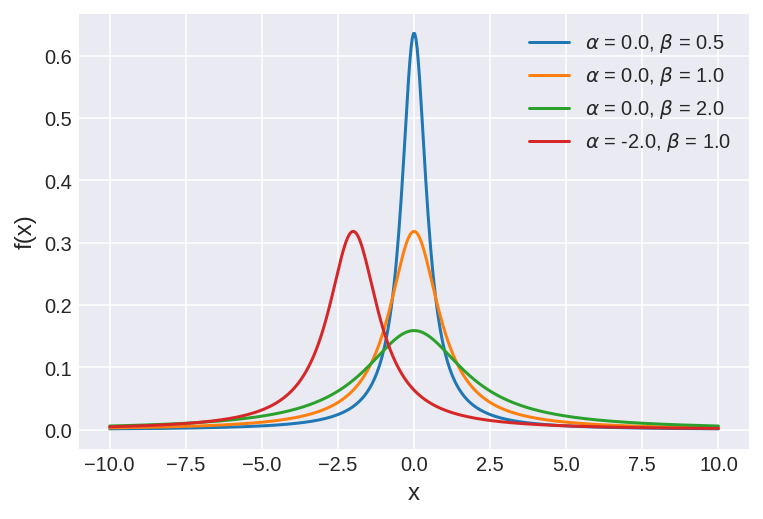

In [2]:
x = np.linspace(-10, 10, 500)
alphas = [0., 0., 0., -2.]
betas = [.5, 1., 2., 1.]
for a, b in zip(alphas, betas):
    pdf = st.cauchy.pdf(x, loc=a, scale=b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

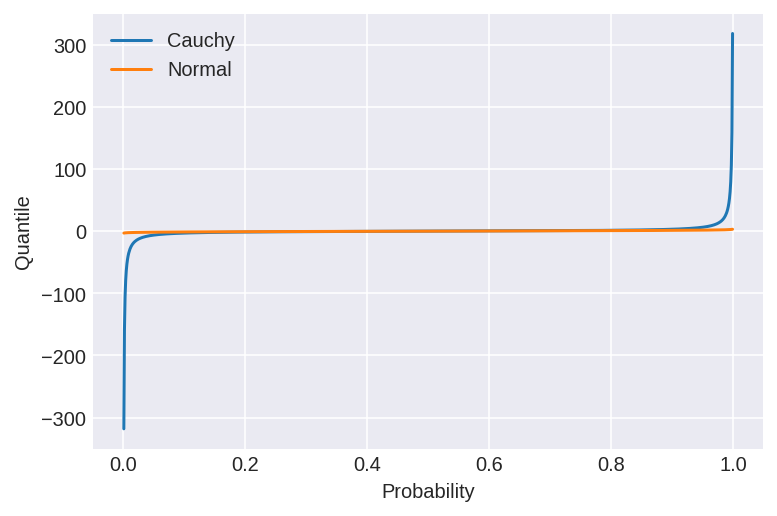

In [3]:
x = np.linspace(0., 1, 1000)
plt.plot(x, st.cauchy.ppf(x, 0., 1.), label='Cauchy')
plt.plot(x, st.norm.ppf(x, 0., 1.), label='Normal')
plt.xlabel('Probability')
plt.ylabel('Quantile')
plt.legend();

In [4]:
def plot_estimated_quantiles(fit, title):
    params = fit['x']
    probs = np.asarray([5, 50, 95])
    cred = np.percentile(params, probs, axis=0)
    _, ax = plt.subplots(1, 1)
    ax.hist(cred.T, bins=np.linspace(-10, 10, 100), 
        color=('r', 'r', 'r'), histtype='barstacked', alpha=.75)
    ax.vlines(st.cauchy.ppf(probs/100, 0., 1.), 0, 50, color='r', alpha=.25)
    return ax

In [5]:
n = 50

## The Nominal Implementation of the Cauchy Distribution

In [6]:
with pm.Model() as cauchy_nom:
    x = pm.Cauchy('x', 0., 1., shape=n)
    fit_nom = pm.sample(11000, tune=1000, nuts_kwargs=dict(max_treedepth=20))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
  2%|▏         | 265/12000 [00:05<03:48, 51.34it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '7844' (I am process '7845')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
  2%|▏         | 269/12000 [00:05<03:51, 50.65it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '7844' (I am process '7846')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
  5%|▍         | 548/12000 [00:12<04:29, 42.48it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '7845' (I am process '7846')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/

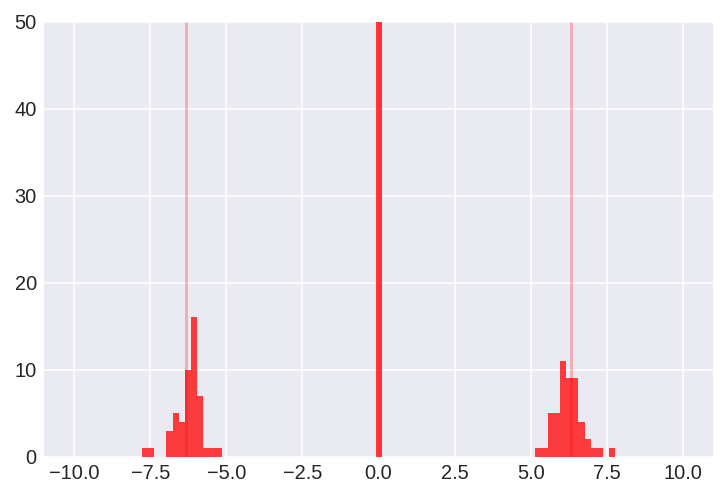

In [7]:
plot_estimated_quantiles(fit_nom, 'Nominal Parameterization');

## First Alternative Implementation

$x_a \sim \text{Normal}(0, 1)$  
$x_b \sim \text{Gamma}(\dfrac{1}{2}, \dfrac{s^2}{2})$  
then  
$x = m+ \dfrac{x_a}{\sqrt x_b} \sim \text{Cauchy}(m, s)$

In [8]:
with pm.Model() as cauchy_alt_1:
    x_a = pm.Normal('x_a', 0., 1., shape=n)
    x_b = pm.Gamma('x_b', .5, .5, shape=n)
    x = pm.Deterministic('x', x_a/tt.sqrt(x_b))
    fit_1 = pm.sample(11000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_b_log__, x_a]
100%|██████████| 12000/12000 [00:17<00:00, 675.25it/s]


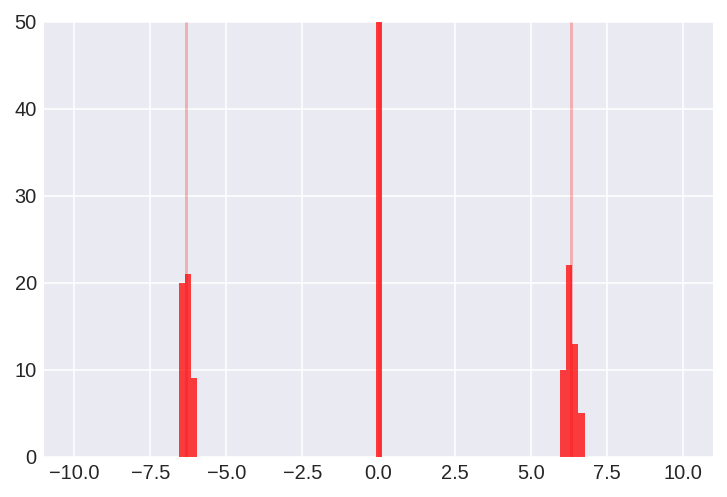

In [9]:
plot_estimated_quantiles(fit_1, 'First Alternative');

## Second Alternative Implementation

$x_a \sim \text{Normal}(0, 1)$  
$x_b \sim \text{InverseGamma}(\dfrac{1}{2}, \dfrac{s^2}{2})$  
then  
$x = m+ x_a * \sqrt x_b \sim \text{Cauchy}(m, s)$

In [10]:
with pm.Model() as cauchy_alt_2:
    x_a = pm.Normal('x_a', 0., 1., shape=n)
    x_b = pm.InverseGamma('x_b', .5, .5, shape=n)
    x = pm.Deterministic('x', x_a*tt.sqrt(x_b))
    fit_2 = pm.sample(11000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_b_log__, x_a]
100%|██████████| 12000/12000 [00:18<00:00, 641.42it/s]


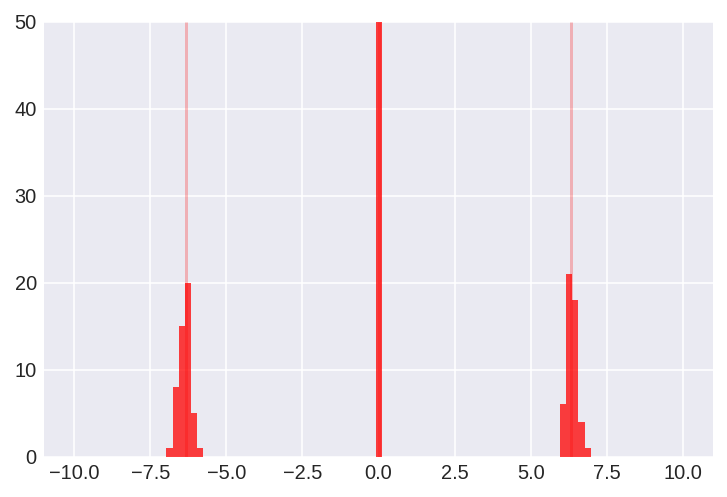

In [11]:
plot_estimated_quantiles(fit_2, 'Second Alternative');

## Third Alternative Implementation

$\tilde{x} \sim \text{Uniform}(0, 1)$  
then  
$x = m + s * \text{tan}(\pi(\tilde{x}-\dfrac{1}{2})) \sim \text{Cauchy}(m, s)$

In [12]:
with pm.Model() as cauchy_alt_3:
    x_tilde = pm.Uniform('x_tilde', 0., 1., shape=n)
    x = pm.Deterministic('x', tt.tan(np.pi*(x_tilde - .5)))
    fit_3 = pm.sample(11000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_tilde_interval__]
100%|██████████| 12000/12000 [00:09<00:00, 1311.62it/s]


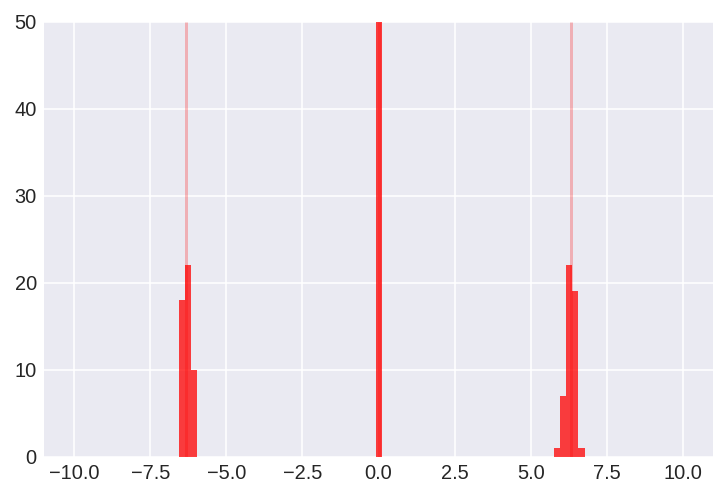

In [13]:
plot_estimated_quantiles(fit_3, 'Third Alternative');

Following the discussion:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Compute the k-hat value? If it’s &gt;1 then the sample can’t be distinguished from one with infinite mean <a href="https://t.co/RJUqXYOu9P">https://t.co/RJUqXYOu9P</a></p>&mdash; Dan Simpson (@dan_p_simpson) <a href="https://twitter.com/dan_p_simpson/status/988941085803274243?ref_src=twsrc%5Etfw">April 25, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [24]:
def plot_khat(ks, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.hlines([0, .5, .7, 1], xmin=-1, xmax=len(ks)+1,
              alpha=.25, color='r')

    alphas = .5 + .5*(ks>.5)
    rgba_c = np.zeros((len(ks), 4))
    rgba_c[:, 2] = .8
    rgba_c[:, 3] = alphas
    ax.scatter(np.arange(len(ks)), ks, c=rgba_c, marker='+')

    ax.set_xlabel('Data point')
    ax.set_ylabel(r'Shape parameter $\kappa$')
    return ax

In [31]:
_, ks = pm.stats._psislw(fit_1['x'], 1)
ks

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

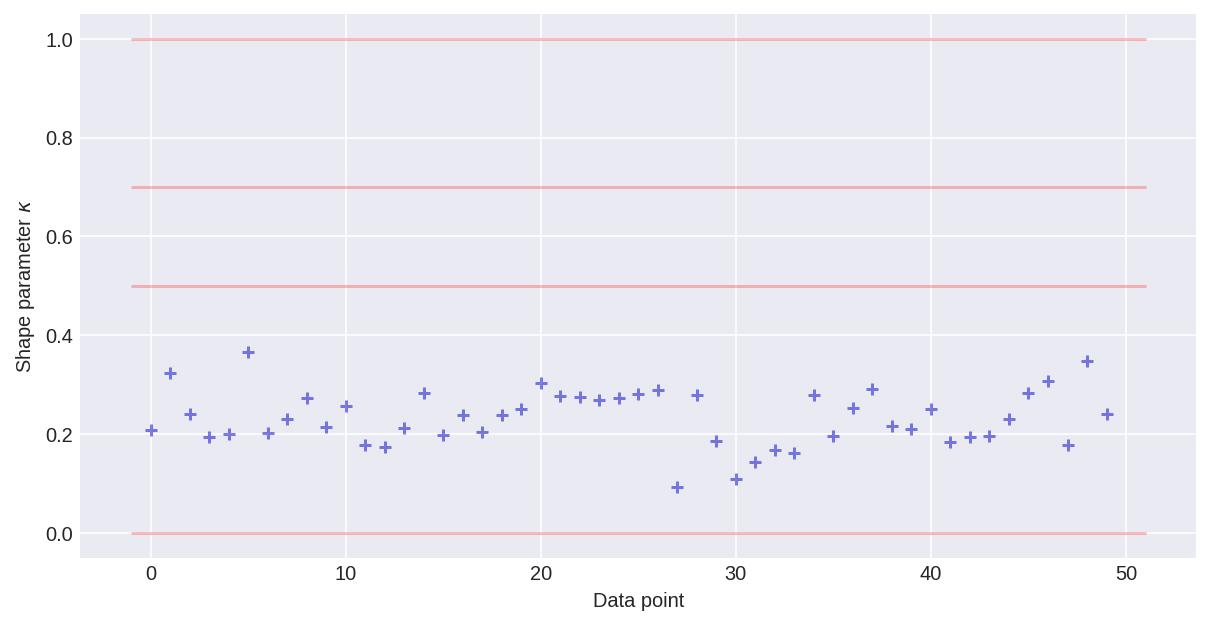

In [30]:
_, ks = pm.stats._psislw(fit_1['x_a'], 1)
plot_khat(ks, ax=None);

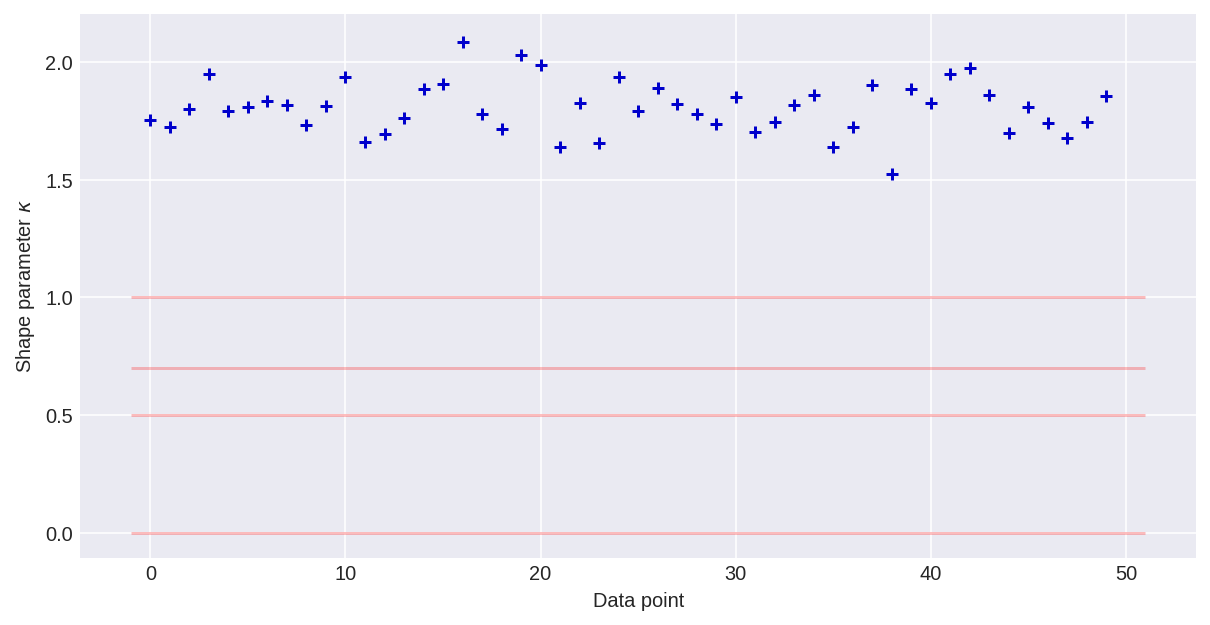

In [29]:
_, ks = pm.stats._psislw(fit_1['x_b'], 1)
plot_khat(ks, ax=None);